In [1]:
from _utils import *

folder_path = '/mnt/home/tudomlumleart/ceph/05_Sox9Dataset/'
    
num_monomers = 80

# Load polys data and then perform linear interpolation
# List all .mat files in the folder and load them
cnc_polys = scipy.io.loadmat(folder_path + 'cncPols.mat')['cncPols'][:num_monomers, :, :]
esc_polys = scipy.io.loadmat(folder_path + 'escPols.mat')['escPols'][:num_monomers, :, :]

esc_polys_interp = interpolate_polymers(esc_polys)
cnc_polys_interp = interpolate_polymers(cnc_polys)

esc_maps_interp = np.array([squareform(pdist(esc_polys_interp[:80, :, i])) for i in range(esc_polys_interp.shape[2])])
cnc_maps_interp = np.array([squareform(pdist(cnc_polys_interp[:80, :, i])) for i in range(cnc_polys_interp.shape[2])])
esc_maps_interp_flat = np.array([x.flatten() for x in esc_maps_interp])
cnc_maps_interp_flat = np.array([x.flatten() for x in cnc_maps_interp])
all_maps_interp = np.concatenate((esc_maps_interp, cnc_maps_interp), axis=0)
all_maps_interp_flat = np.concatenate((esc_maps_interp_flat, cnc_maps_interp_flat), axis=0)

pca = PCA(n_components=2)
pca.fit(all_maps_interp_flat)
esc_maps_pca = pca.transform(esc_maps_interp_flat)
cnc_maps_pca = pca.transform(cnc_maps_interp_flat)

esc_df = pd.DataFrame(esc_maps_pca, columns=['PC1', 'PC2'])
esc_df['label'] = 'ESC'
cnc_df = pd.DataFrame(cnc_maps_pca, columns=['PC1', 'PC2'])
cnc_df['label'] = 'CNC'
all_df = pd.concat([esc_df, cnc_df], axis=0)

# Find lower bound and upper bound of PC1 and PC2 data
pc1_l = all_df['PC1'].min()
pc1_u = all_df['PC1'].max()
pc2_l = all_df['PC2'].min()
pc2_u = all_df['PC2'].max()

pc1_grid = np.linspace(pc1_l, pc1_u, 75)
pc2_grid = np.linspace(pc2_l, pc2_u, 75)

# Generate combination of pc1 and pc2 values
pc1_grid, pc2_grid = np.meshgrid(pc1_grid, pc2_grid)

# put this into a dataframe
pc1_grid_flat = pc1_grid.flatten()
pc2_grid_flat = pc2_grid.flatten()
pc1_pc2_df = pd.DataFrame({'PC1': pc1_grid_flat, 'PC2': pc2_grid_flat})
pc1_pc2_df['label'] = 'metastructures'

# Sort PC2 in descending order while keeping PC1 in ascending order
pc1_pc2_df = pc1_pc2_df.sort_values(by=['PC1', 'PC2'], ascending=[True, False], ignore_index=True)  

metastr_from_pca = pca.inverse_transform(pc1_pc2_df[['PC1', 'PC2']])   

2024-09-23 14:12:05.936972: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-23 14:12:06.284253: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI AVX512_BF16, in other operations, rebuild TensorFlow with the appropriate compiler flags.


<Axes: xlabel='PC1', ylabel='PC2'>

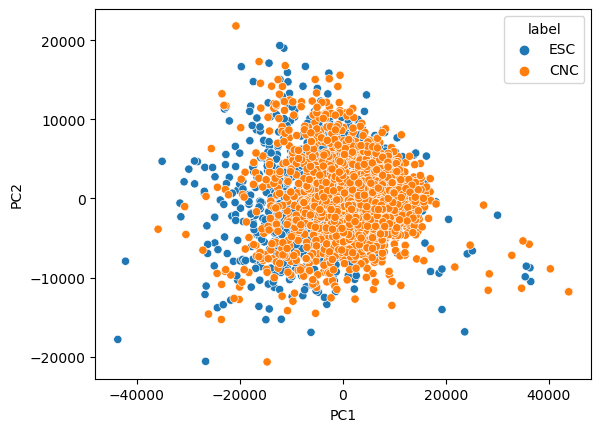

In [44]:
sns.scatterplot(x='PC1', y='PC2', hue='label', data=all_df)

In [2]:
common_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/MCMC_results/20240920_RunWeightMCMC_Sox9_PCA_minmax_utilsV4/'
stan_directory_esc = os.path.join(common_dir, 'ESC/stan_output')
stan_directory_cnc = os.path.join(common_dir, 'CNC/stan_output')

In [3]:
esc_log_weights = load_weights(stan_directory_esc, 75**2)
cnc_log_weights = load_weights(stan_directory_cnc, 75**2)

esc_weights_all = np.exp(np.array(esc_log_weights))
cnc_weights_all = np.exp(np.array(cnc_log_weights))

esc_weights_all = esc_weights_all.reshape(-1, 75**2)
cnc_weights_all = cnc_weights_all.reshape(-1, 75**2)

esc_entropy_all = np.array([scipy.stats.entropy(x) for x in esc_weights_all])
cnc_entropy_all = np.array([scipy.stats.entropy(x) for x in cnc_weights_all])

# Put these data in dataframe 
esc_entropy_df = pd.DataFrame({'entropy': esc_entropy_all, 'label': 'ESC'})
cnc_entropy_df = pd.DataFrame({'entropy': cnc_entropy_all, 'label': 'NPC'})

all_entropy_df = pd.concat([esc_entropy_df, cnc_entropy_df], axis=0)

['20240715_WeightOptimization-20240920191647_1.csv', '20240715_WeightOptimization-20240920191647_2.csv', '20240715_WeightOptimization-20240920191647_3.csv', '20240715_WeightOptimization-20240920191647_4.csv']
['20240715_WeightOptimization-20240920193035_1.csv', '20240715_WeightOptimization-20240920193035_2.csv', '20240715_WeightOptimization-20240920193035_3.csv', '20240715_WeightOptimization-20240920193035_4.csv']


In [96]:
import matplotlib

esc_weights = np.mean(np.exp(np.array(esc_log_weights)), axis=(0, 1))
cnc_weights = np.mean(np.exp(np.array(cnc_log_weights)), axis=(0, 1))

# Put weights in a DataFrame
esc_weights_df = pd.DataFrame({'PC1': pc1_pc2_df['PC1'].values,
                               'PC2': pc1_pc2_df['PC2'].values,  
                               'weight': esc_weights})
esc_weights_df['label'] = 'ESC'
cnc_weights_df = pd.DataFrame({'PC1': pc1_pc2_df['PC1'].values,
                               'PC2': pc1_pc2_df['PC2'].values, 
                               'weight': cnc_weights})
cnc_weights_df['label'] = 'CNC'

In [63]:
# Calculate log prior for each metastructure 
lpm = [(logprior(x, num_monomers)).tolist() for x in metastr_from_pca]

In [49]:
lpm

[-1703.0028590001539,
 -1701.1202827969657,
 -1699.2231808734944,
 -1697.3113360390016,
 -1695.3845264200033,
 -1693.4425253330799,
 -1691.4851011537603,
 -1689.5120171813699,
 -1687.5230314997132,
 -1685.5178968334765,
 -1683.4963604002278,
 -1681.4581637578885,
 -1679.4030426475572,
 -1677.3307268315598,
 -1675.2409399266087,
 -1673.1333992319474,
 -1671.0078155523643,
 -1668.8638930159657,
 -1666.7013288865942,
 -1664.5198133707952,
 -1662.3190294192327,
 -1660.0986525224741,
 -1657.8583505010672,
 -1655.597783289852,
 -1653.316602716465,
 -1651.0144522740138,
 -1648.690966887923,
 -1646.3457726769786,
 -1643.9784867086366,
 -1641.5887167486892,
 -1639.1760610054366,
 -1636.7401078685518,
 -1634.280435642899,
 -1631.7966122776193,
 -1629.288195090887,
 -1626.754730490828,
 -1624.1957536931914,
 -1621.6107884364944,
 -1618.9993466954954,
 -1616.360928394004,
 -1613.6950211182357,
 -1611.001099832112,
 -1608.2786265961668,
 -1605.5270502919823,
 -1602.745806354419,
 -1599.934316514253

In [77]:
lpm > -10000

array([ True,  True,  True, ..., False, False, False])

In [168]:
save_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/figures/20240923/'

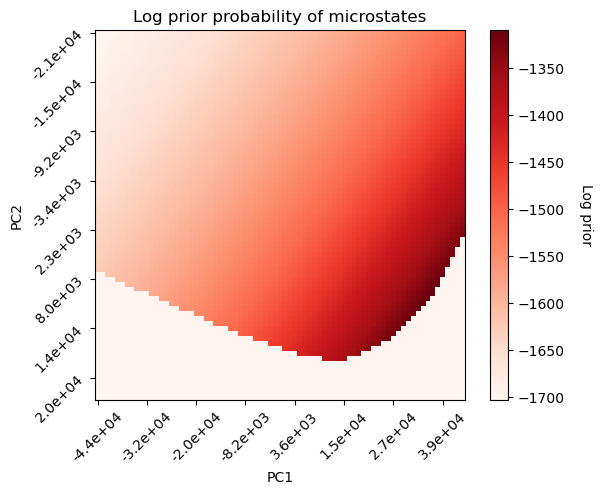

In [169]:
# norm=LogNorm(vmin=lpm.min(), vmax=lpm.max())
lpm = np.array(lpm)
plt.imshow(np.reshape(lpm, [75, 75]), cmap='Reds', vmax=(lpm[lpm > -10000]).max(), vmin=(lpm[lpm > -10000]).min())
xlabel = np.array([f"{x:.1e}" for x in cnc_weights_df['PC1'].unique()])[::10]
ylabel = np.array([f"{x:.1e}" for x in cnc_weights_df['PC2'].unique()])[::-10]
plt.xticks(np.arange(0, 75, 10), xlabel, rotation=45)
plt.yticks(np.arange(0, 75, 10), ylabel, rotation=45)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Log prior probability of microstates')
cbar = plt.colorbar()
cbar.set_label('Log prior', rotation=270, labelpad=20)
plt.savefig(os.path.join(save_dir, 'log_prior.png'), dpi=300, bbox_inches='tight')

In [134]:
contour_length = [np.sum(np.diag(x.reshape(80, 80), 1)) for x in metastr_from_pca]
contour_length = np.array(contour_length)

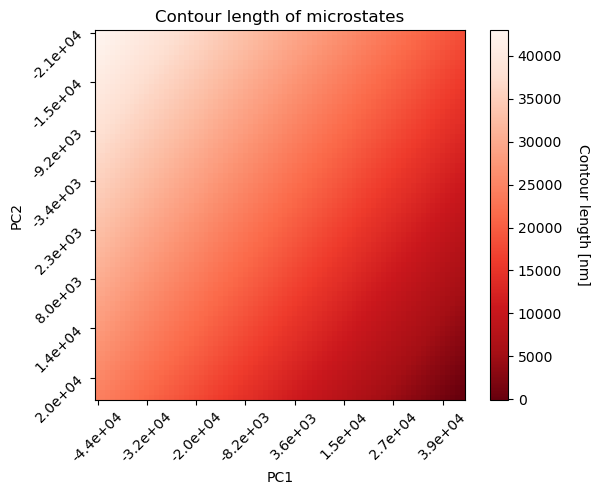

In [170]:
plt.imshow(contour_length.reshape(75, 75), cmap='Reds_r')
cbar = plt.colorbar()
cbar.set_label('Contour length [nm]', rotation=270, labelpad=20)
plt.title('Contour length of microstates')
xlabel = np.array([f"{x:.1e}" for x in cnc_weights_df['PC1'].unique()])[::10]
ylabel = np.array([f"{x:.1e}" for x in cnc_weights_df['PC2'].unique()])[::-10]
plt.xticks(np.arange(0, 75, 10), xlabel, rotation=45)
plt.yticks(np.arange(0, 75, 10), ylabel, rotation=45)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.savefig(os.path.join(save_dir, 'contour_length.png'), dpi=300, bbox_inches='tight')

In [142]:
negative_mask = [np.any(x < -1) for x in metastr_from_pca]
negative_mask = np.array(negative_mask)

In [164]:
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.ticker import ScalarFormatter, LogFormatter

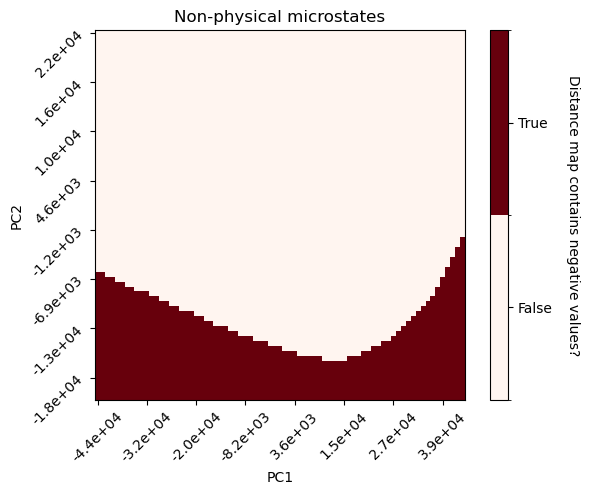

In [182]:

bounds = [0, 0.5, 1]
# Use the 'Reds' colormap
cmap = plt.get_cmap('Reds')

# Create a normalization based on the bounds
norm = BoundaryNorm(bounds, cmap.N)

# Create the heatmap with the custom colormap and norm
plt.imshow(negative_mask.reshape(75, 75), cmap=cmap, norm=norm)
norm = BoundaryNorm(bounds, cmap.N)
cbar = plt.colorbar(ticks=[0.25, 0.75])
cbar.set_ticklabels(['False', 'True'])
cbar.set_label('Distance map contains negative values?', rotation=270, labelpad=20)
xlabel = np.array([f"{x:.1e}" for x in cnc_weights_df['PC1'].unique()])[::10]
ylabel = np.array([f"{x:.1e}" for x in cnc_weights_df['PC2'].unique()])[::10]
plt.xticks(np.arange(0, 75, 10), xlabel, rotation=45)
plt.yticks(np.arange(0, 75, 10), ylabel, rotation=45)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Non-physical microstates')
plt.savefig(os.path.join(save_dir, 'microstates_physicality.png'), dpi=300, bbox_inches='tight')

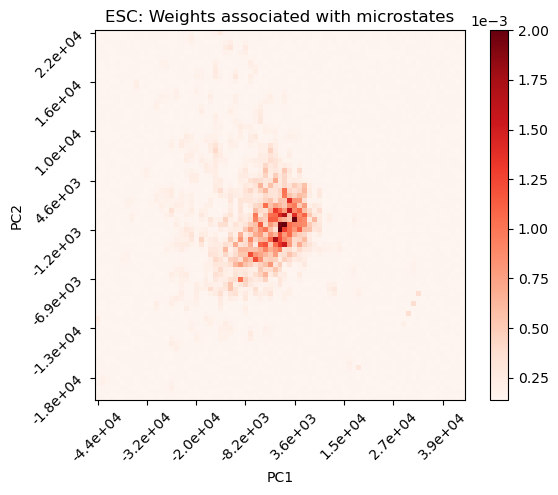

In [172]:
plt.imshow(esc_weights_df['weight'].values.reshape(75, 75).T,
           cmap='Reds', vmin=esc_weights_df['weight'].values.min(), vmax=0.002)
# set xticks 
xlabel = np.array([f"{x:.1e}" for x in cnc_weights_df['PC1'].unique()])[::10]
ylabel = np.array([f"{x:.1e}" for x in cnc_weights_df['PC2'].unique()])[::10]
plt.xticks(np.arange(0, 75, 10), xlabel, rotation=45)
plt.yticks(np.arange(0, 75, 10), ylabel, rotation=45)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('ESC: Weights associated with microstates')
cbar = plt.colorbar()
formatter = ScalarFormatter()
formatter.set_powerlimits((0, 0))  # Forces scientific notation for all ticks
cbar.ax.yaxis.set_major_formatter(formatter)
plt.savefig(os.path.join(save_dir, 'esc_weights_75x75.png'), dpi=300, bbox_inches='tight')

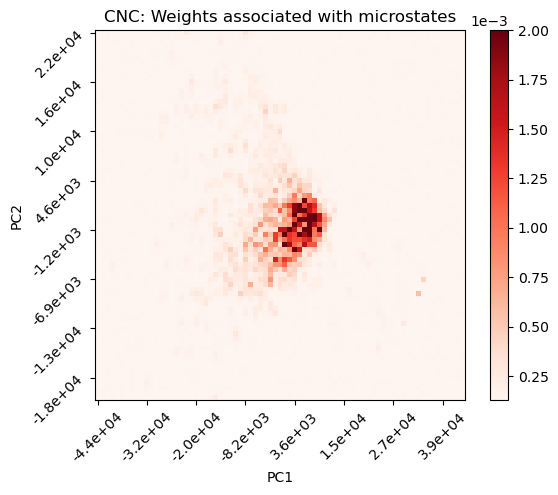

In [173]:
plt.imshow(cnc_weights_df['weight'].values.reshape(75, 75).T,
           cmap='Reds', vmin=cnc_weights_df['weight'].values.min(), vmax=0.002)
# set xticks 
xlabel = np.array([f"{x:.1e}" for x in cnc_weights_df['PC1'].unique()])[::10]
ylabel = np.array([f"{x:.1e}" for x in cnc_weights_df['PC2'].unique()])[::10]
plt.xticks(np.arange(0, 75, 10), xlabel, rotation=45)
plt.yticks(np.arange(0, 75, 10), ylabel, rotation=45)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('CNC: Weights associated with microstates')
cbar = plt.colorbar()
formatter = ScalarFormatter()
formatter.set_powerlimits((0, 0))  # Forces scientific notation for all ticks
cbar.ax.yaxis.set_major_formatter(formatter)
plt.savefig(os.path.join(save_dir, 'cnc_weights_75x75.png'), dpi=300, bbox_inches='tight')

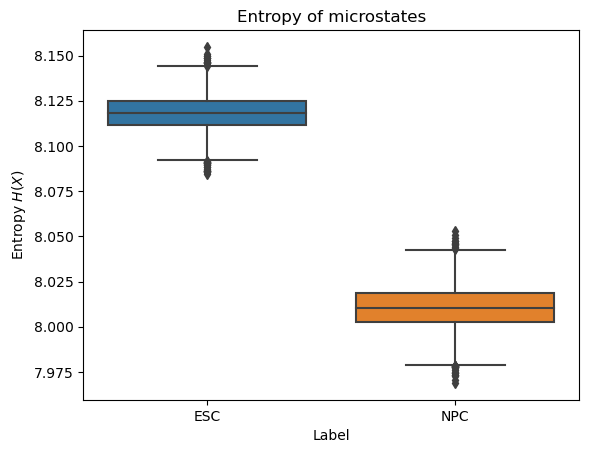

In [174]:
ax = sns.boxplot(x='label', y='entropy', data=all_entropy_df)
plt.xlabel('Label')
plt.ylabel(r'Entropy $H(X)$')
plt.title('Entropy of microstates')
plt.savefig(os.path.join(save_dir, 'entropy_75x75.png'), dpi=300, bbox_inches='tight')

In [183]:
np.log(75*75)  # assuming its a uniform distribution

8.63497622707262

In [11]:
num_metastructures = 75

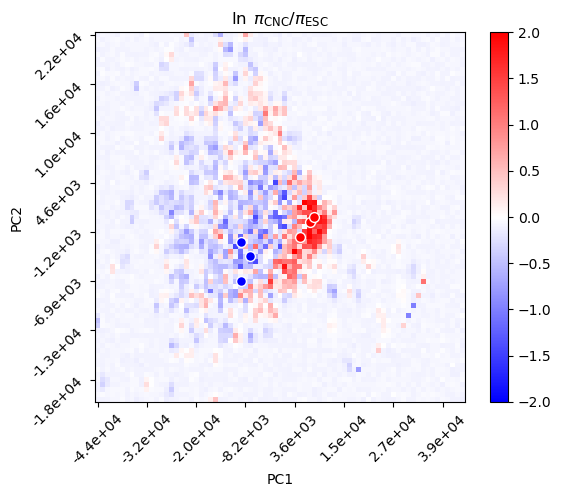

In [175]:
esc_weights_grid = esc_weights_df['weight'].values.reshape(num_metastructures, num_metastructures).T
cnc_weights_grid = cnc_weights_df['weight'].values.reshape(num_metastructures, num_metastructures).T

diff_table = np.log(cnc_weights_grid / esc_weights_grid)

# Flatten the array and get the indices of the top 10 values
flattened_indices = np.argsort(diff_table, axis=None)[-10:]

# Convert the flattened indices back to 2D indices
top_10_indices = np.unravel_index(flattened_indices, diff_table.shape)

# Combine row and column indices into a list of tuples
top_10_indices = list(zip(top_10_indices[0], top_10_indices[1]))

# Flatten the array and get the indices of the top 10 values
flattened_indices = np.argsort(diff_table, axis=None)[:10]

# Convert the flattened indices back to 2D indices
bottom_10_indices = np.unravel_index(flattened_indices, diff_table.shape)

# Combine row and column indices into a list of tuples
bottom_10_indices = list(zip(bottom_10_indices[0], bottom_10_indices[1]))

plt.imshow(np.log(cnc_weights_grid / esc_weights_grid), cmap='bwr', vmin=-2, vmax=2)
plt.colorbar()
plt.xticks(np.arange(0, num_metastructures, 10), [f"{x:.1e}" for x in cnc_weights_df['PC1'].unique()][::10], rotation=45)
plt.yticks(np.arange(0, num_metastructures, 10), [f"{x:.1e}" for x in cnc_weights_df['PC2'].unique()][::10], rotation=45)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(r'$\ln \; \pi_\mathrm{CNC}/ \pi_\mathrm{ESC}$')
# plt.savefig(os.path.join(save_dir, 'prob_ratio.png'), dpi=300, bbox_inches='tight')

# Annotate the top 3 highest values
for i in range(1, 4):
    plt.scatter(top_10_indices[-i][1], top_10_indices[-i][0], color='red', s=50, edgecolor='white')
    # plt.text(top_10_indices[-i][0], top_3_coords[-i][1], f'{data[top_3_coords[0][i], top_3_coords[1][i]]:.2f}', 
    #          color='white', ha='center', va='center', fontsize=9, fontweight='bold')
    
for i in range(3):
    plt.scatter(bottom_10_indices[i][1], bottom_10_indices[i][0], color='blue', s=50, edgecolor='white')

plt.savefig(os.path.join(save_dir, 'cnc_esc_prob_ratio_annotate_75x75.png'), dpi=300, bbox_inches='tight')

In [25]:
# Analyze 2D histogram
pc1_grid_hist = np.linspace(pc1_l, pc1_u, 75)
pc2_grid_hist = np.linspace(pc2_l, pc2_u, 75)

pc1_interval = pc1_grid_hist[1] - pc1_grid_hist[0]
pc2_interval = pc2_grid_hist[1] - pc2_grid_hist[0]

pc1_bin_edges = np.concatenate((pc1_grid_hist - pc1_interval / 2, [pc1_grid_hist[-1] + pc1_interval / 2]))
pc2_bin_edges = np.concatenate((pc2_grid_hist - pc2_interval / 2, [pc2_grid_hist[-1] + pc2_interval / 2]))

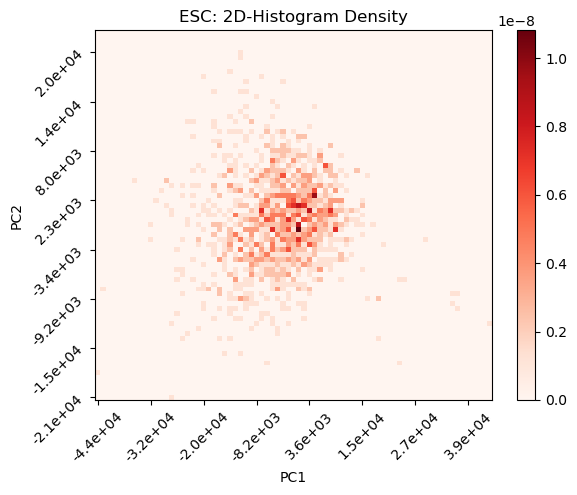

In [176]:
# Create the 2D histogram using numpy.histogram2d
H_esc, x_edges, y_edges = np.histogram2d(esc_df.PC1, esc_df.PC2, bins=[pc1_bin_edges, pc2_bin_edges], density=True)

# Plotting the 2D histogram using plt.imshow
plt.imshow(H_esc.T, origin='lower', aspect='auto', cmap='Reds')
xlabel = np.array([f"{x:.1e}" for x in pc1_grid_hist])[::10]
ylabel = np.array([f"{x:.1e}" for x in pc2_grid_hist])[::10]
plt.xticks(np.arange(0, 75, 10), xlabel, rotation=45)
plt.yticks(np.arange(0, 75, 10), ylabel, rotation=45)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('ESC: 2D-Histogram Density')
plt.colorbar()
plt.savefig(os.path.join(save_dir, 'esc_hist_2d_75x75.png'), dpi=300, bbox_inches='tight')

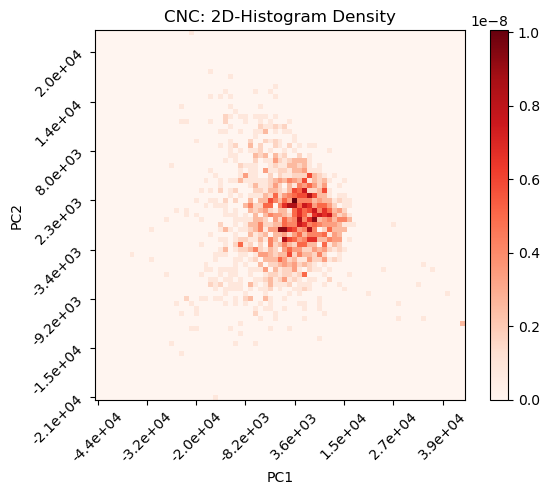

In [178]:
# Create the 2D histogram using numpy.histogram2d
H_cnc, x_edges, y_edges = np.histogram2d(cnc_df.PC1, cnc_df.PC2, bins=[pc1_bin_edges, pc2_bin_edges], density=True)

# Plotting the 2D histogram using plt.imshow
plt.imshow(H_cnc.T, origin='lower', cmap='Reds')
xlabel = np.array([f"{x:.1e}" for x in pc1_grid_hist])[::10]
ylabel = np.array([f"{x:.1e}" for x in pc2_grid_hist])[::10]
plt.xticks(np.arange(0, 75, 10), xlabel, rotation=45)
plt.yticks(np.arange(0, 75, 10), ylabel, rotation=45)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('CNC: 2D-Histogram Density')
plt.colorbar()
plt.savefig(os.path.join(save_dir, 'cnc_hist_2d_75x75.png'), dpi=300, bbox_inches='tight')

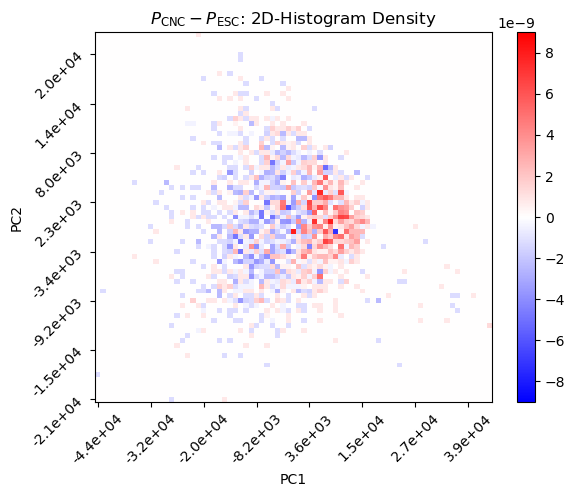

In [180]:
plt.imshow(H_cnc.T - H_esc.T, origin='lower', aspect='auto', cmap='bwr', vmin=-9E-9, vmax=9E-9)
xlabel = np.array([f"{x:.1e}" for x in cnc_weights_df['PC1'].unique()])[::10]
ylabel = np.array([f"{x:.1e}" for x in cnc_weights_df['PC2'].unique()])[::-10]
plt.xticks(np.arange(0, 75, 10), xlabel, rotation=45)
plt.yticks(np.arange(0, 75, 10), ylabel, rotation=45)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(r'$P_\mathrm{CNC} - P_\mathrm{ESC}$: 2D-Histogram Density')
plt.colorbar()
plt.savefig(os.path.join(save_dir, 'esc_cnc_diff_2d_75x75.png'), dpi=300, bbox_inches='tight')

/tmp/ipykernel_1856892/3716288567.py:1: RuntimeWarning: divide by zero encountered in divide
  plt.imshow(np.log(H_cnc.T/H_esc.T), origin='lower', aspect='auto', cmap='bwr', vmin=-2, vmax=2)
/tmp/ipykernel_1856892/3716288567.py:1: RuntimeWarning: invalid value encountered in divide
  plt.imshow(np.log(H_cnc.T/H_esc.T), origin='lower', aspect='auto', cmap='bwr', vmin=-2, vmax=2)
/tmp/ipykernel_1856892/3716288567.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(H_cnc.T/H_esc.T), origin='lower', aspect='auto', cmap='bwr', vmin=-2, vmax=2)


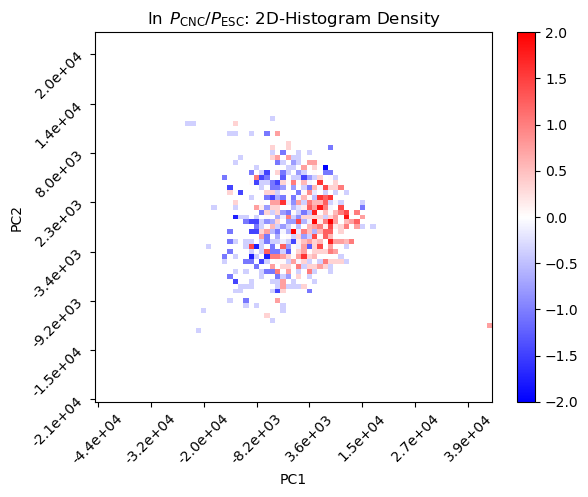

In [181]:
plt.imshow(np.log(H_cnc.T/H_esc.T), origin='lower', aspect='auto', cmap='bwr', vmin=-2, vmax=2)
xlabel = np.array([f"{x:.1e}" for x in cnc_weights_df['PC1'].unique()])[::10]
ylabel = np.array([f"{x:.1e}" for x in cnc_weights_df['PC2'].unique()])[::-10]
plt.xticks(np.arange(0, 75, 10), xlabel, rotation=45)
plt.yticks(np.arange(0, 75, 10), ylabel, rotation=45)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('$\ln \; P_\mathrm{CNC}/ P_\mathrm{ESC}$: 2D-Histogram Density')
plt.colorbar()
plt.savefig(os.path.join(save_dir, 'esc_cnc_ratio_hist_2d_75x75.png'), dpi=300, bbox_inches='tight')

In [83]:
scipy.stats.entropy(H_cnc.flatten())

6.282379059788619

In [84]:
scipy.stats.entropy(H_esc.flatten())

6.35020131847109